# GPS Data Preprocessing and Analysis

This notebook preprocesses GPS data in accordance with Mueller et al. (2021) and performs analyses by splitting the data into two weekly segments.

1. **Load Data**: Load necessary data from pickle files.
2. **Preprocess Data**: Filter and transform the data for analysis.
3. **Split Data**: Divide the data into two parts based on the `ema_base_start` variable.
4. **Analyze Data**: Perform analyses separately for the two parts.
5. **Calculate Retest Reliability**: Evaluate the retest reliability of features between the first and second weeks.


## Load Data

This section loads the necessary data from the pickle files and initializes relevant parameters.


In [1]:
import os
import sys

import glob
import pickle
from IPython.display import Markdown
from config import datapath

# If your current working directory is the notebooks directory, use this:
library_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'library'))
sys.path.append(library_path)

from gps_features import haversine, apply_clustering, identify_home,calculate_metrics, \
calculate_transition_time, calculate_intraclass_coefficient, calculate_retest_reliability, cal_entropy

import pandas as pd
import numpy as np
import datetime as dt

from sklearn.cluster import DBSCAN
import statistics 
import scipy.stats as stats
from scipy.stats import pearsonr
from math import radians, cos, sin, asin, sqrt, log


import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline

In [2]:
today = dt.date.today().strftime("%d%m%Y")
today_day = pd.to_datetime('today').normalize()

with open(datapath + f'ema_data.pkl', 'rb') as file:
    df_active = pickle.load(file)

with open(datapath + f'gps_data.pkl', 'rb') as file:
    df_gps = pickle.load(file)
    
with open(datapath + f'passive_data.pkl', 'rb') as file:
    df_passive = pickle.load(file)

with open(datapath + f'monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

## Configurations

In [3]:
min_hour_daily = 4
min_days_data = 14

#stationary filtering
max_distance = 150 
speed_limit = 1.4  # Max allowed speed in m/s

# DBSCAN
kms_per_radian = 6371.0088 # equitorial radius of the earth = 6,371.1 
epsilon = 0.03/kms_per_radian
min_samples = 10

# Kmeans
DKmeans = 500

#home featurenight
min_nights_obs = 4
min_f_home = 0.5  

# EMA
min_num_daily = 4
min_days_data = 10

# Preprocess Data

Filter and transform the data as per the requirements.


## Prepare the PD dataframe

In [4]:
df_passive = df_passive.loc[df_passive.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2"])]
df_passive = df_passive[df_passive['startTimestamp'] <= df_passive['ema_end_date']]

In [5]:
df_steps = df_passive.loc[df_passive.type.isin(['Steps'])][["customer","type","startTimestamp",  "endTimestamp", "doubleValue",
                                                      'startTimestamp_day','startTimestamp_hour', 'ema_start_date','ema_end_date']]

In [6]:
# Rename the columns for clarity
df_steps = df_steps.rename(columns={
    'startTimestamp': 'startTimestamp_steps',
    'endTimestamp': 'endTimestamp_steps',
    'startTimestamp_day': 'day_steps',  # Keeping one 'Day' column
    'startTimestamp_hour_Latitude': 'hour_steps'  # Keeping one 'Hour' column
})

In [7]:
df_steps["daily_steps"] = df_steps.groupby(["customer", "day_steps"])["doubleValue"].transform("sum")


## Prepare the GPS dataframe

In [8]:
# Filter for participants that have finished 1. EMA Phase

df_gps = df_gps.loc[df_gps.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2"])]

In [9]:
df_gps = df_gps[df_gps['startTimestamp'] <= df_gps['ema_end_date']]

In [10]:
df_gps.customer.nunique()

113

In [11]:
df_int = df_gps.pivot_table(
    index=["customer", "startTimestamp", "ema_start_date"],
    columns="type",
    values=["doubleValue", "startTimestamp_hour", "startTimestamp_day"],
    aggfunc='first'  # Using 'first' since each type should theoretically have only one entry per customer and timestamp
)

# Flatten the MultiIndex in columns
df_int.columns = ['_'.join(col).strip() for col in df_int.columns.values]

df_int = df_int.rename_axis(None, axis=1).reset_index()

# Drop redundant day and hour columns for longitude (assuming latitude day and hour are kept)
df_int = df_int.drop(columns=[
    'startTimestamp_day_Longitude',
    'startTimestamp_hour_Longitude'
])

# Rename the columns for clarity
df_int = df_int.rename(columns={
    'doubleValue_Latitude': 'Latitude',
    'doubleValue_Longitude': 'Longitude',
    'startTimestamp_day_Latitude': 'day_gps',  # Keeping one 'Day' column
    'startTimestamp_hour_Latitude': 'hour_gps'  # Keeping one 'Hour' column
})

df_int['weekday'] = df_int['day_gps'].dt.day_name()
df_int["n_hours"] = df_int.groupby(["customer", "day_gps"])["hour_gps"].transform("nunique")
df_int["n_data"] = df_int.groupby("customer")["Longitude"].transform("size")
df_int["n_data_day"] = df_int.groupby(["customer", "day_gps"])["Longitude"].transform("size")
df_int["n_data_hour"] = df_int.groupby(["customer", "hour_gps"])["Longitude"].transform("size")

In [12]:
df_int.groupby("customer")["n_hours"].min().mean()

3.743362831858407

In [13]:
df_int.groupby("customer")["n_data_day"].mean().min()

2.0

In [14]:
df_int.groupby("customer")["n_data_day"].mean().max()

3406.2527969461166

In [15]:
df_int.customer.nunique()

113

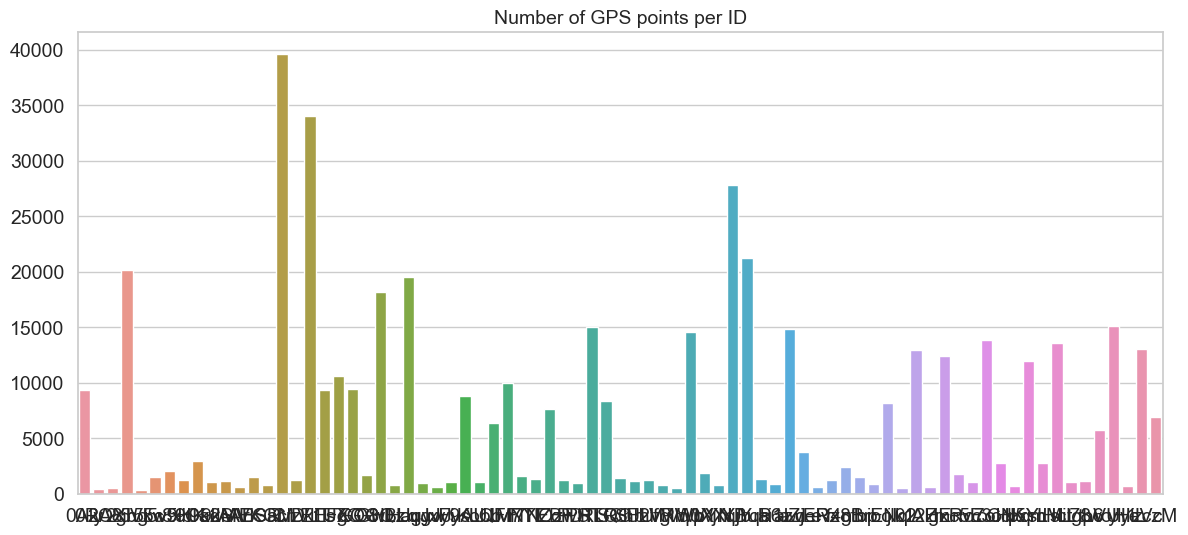

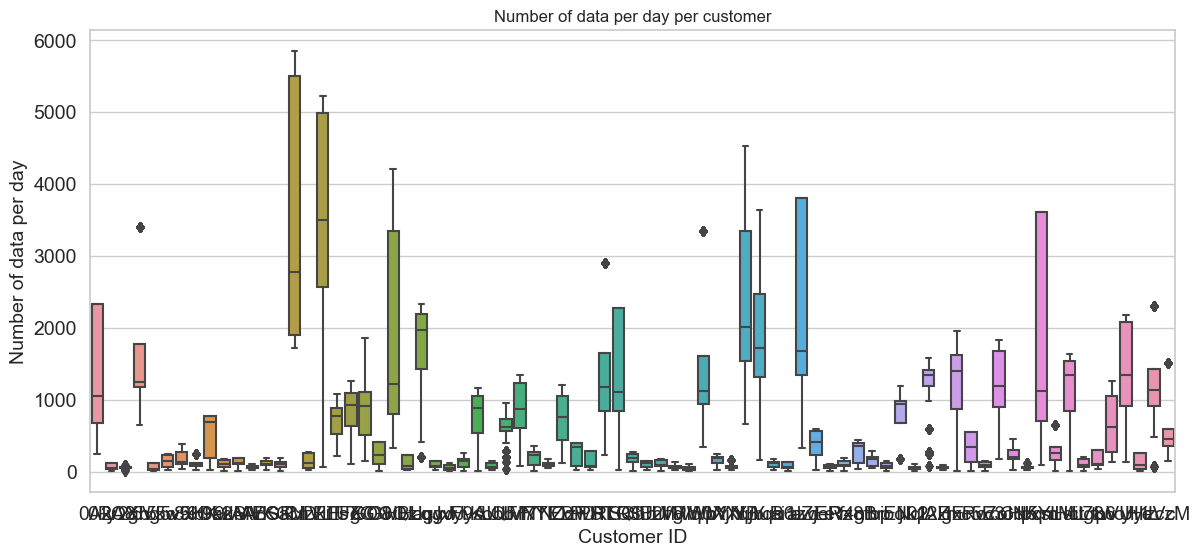

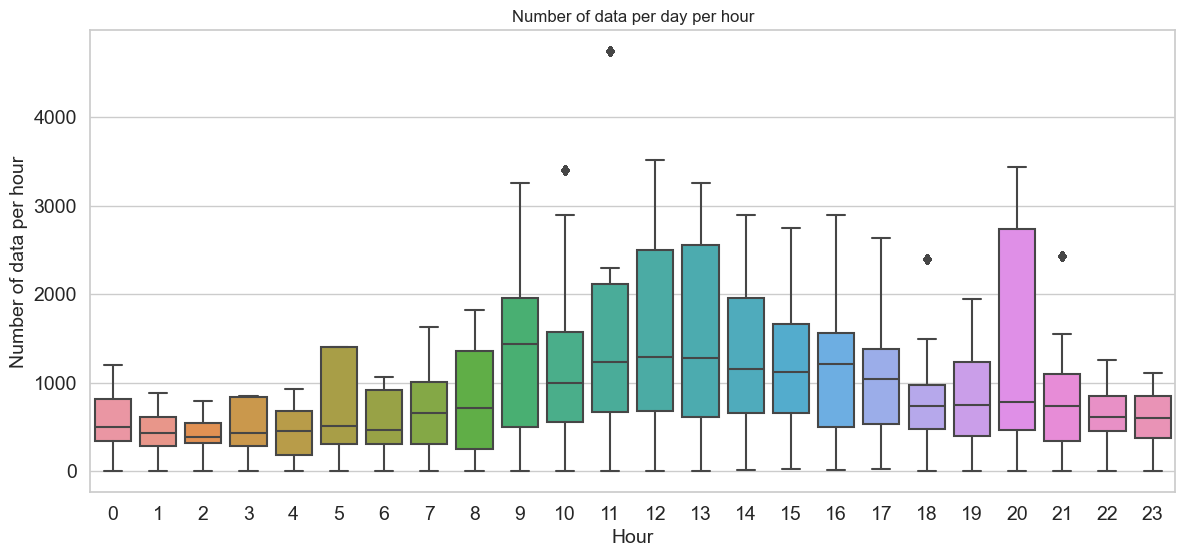

In [16]:
df_int = df_int.loc[df_int["n_hours"] >= min_hour_daily]
df_int["n_days_8"] = df_int.groupby("customer")["day_gps"].transform("nunique")
df_int = df_int.loc[df_int["n_days_8"] >= min_days_data]

# Ensure your DataFrame is sorted by customer and day
df_int = df_int.sort_values(by=['customer', 'day_gps'])

plt.figure(figsize=(14, 6))
sns.barplot(x='customer', y='n_data', data=df_int)
plt.title('Number of GPS points per ID',fontsize=14)
plt.ylabel('')
plt.xlabel('')

#plt.savefig("barplot_high_quality.png", dpi=300, format='png', bbox_inches='tight')
# Showing the plot
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='customer', y='n_data_day', data=df_int)
plt.title('Number of data per day per customer')
plt.ylabel('Number of data per day')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='hour_gps', y='n_data_hour', data=df_int)
plt.title('Number of data per day per hour')
plt.ylabel('Number of data per hour')
plt.xlabel('Hour')

# Showing the plot
plt.show()

## Split Data

Divide the `df_int` dataframe into two parts based on the `ema_base_start` variable. The first part covers the first week of data, and the second part covers the following week.


In [17]:
# Convert 'day_gps' and 'ema_base_start' to datetime if not already
df_int['day_gps'] = pd.to_datetime(df_int['day_gps'])
df_int['ema_start_date'] = pd.to_datetime(df_int['ema_start_date'])

# Define the time boundaries for the first and second week
df_int['first_week_end'] = df_int['ema_start_date'] + pd.Timedelta(days=8)
df_int['second_week_end'] = df_int['ema_start_date'] + pd.Timedelta(days=15)

# Filter data for the first and second week
first_week_df = df_int[(df_int['day_gps'] >= df_int['ema_start_date']) & 
                       (df_int['day_gps'] < df_int['first_week_end'])].copy()
first_week_df = first_week_df[['customer', 'startTimestamp', 'ema_start_date', 'Latitude', 'Longitude',
       'day_gps', 'hour_gps', 'weekday']]

first_week_df['week'] = 'First Week'
first_week_df["n_data"] = first_week_df.groupby("customer")["Longitude"].transform("size")
first_week_df["n_data_day"] = first_week_df.groupby(["customer", "day_gps"])["Longitude"].transform("size")
first_week_df["n_data_hour"] = first_week_df.groupby(["customer", "hour_gps"])["Longitude"].transform("size")


second_week_df = df_int[(df_int['day_gps'] >= df_int['first_week_end']) & 
                        (df_int['day_gps'] < df_int['second_week_end'])].copy()
second_week_df = second_week_df[['customer', 'startTimestamp', 'ema_start_date', 'Latitude', 'Longitude',
       'day_gps', 'hour_gps', 'weekday']]

second_week_df['week'] = 'Second Week'
second_week_df["n_data"] = second_week_df.groupby("customer")["Longitude"].transform("size")
second_week_df["n_data_day"] = second_week_df.groupby(["customer", "day_gps"])["Longitude"].transform("size")
second_week_df["n_data_hour"] = second_week_df.groupby(["customer", "hour_gps"])["Longitude"].transform("size")


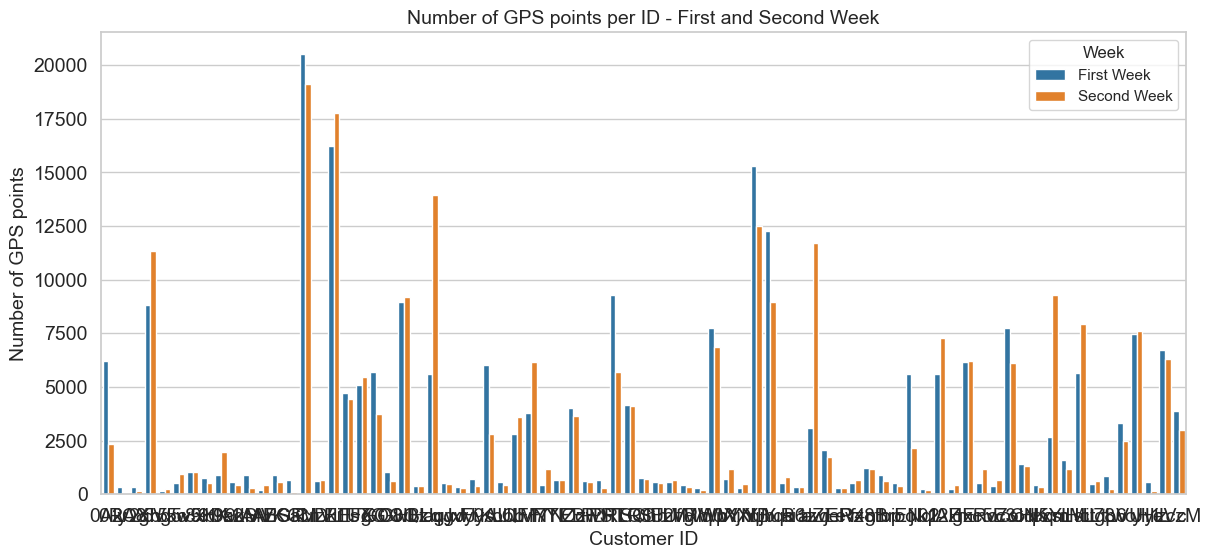

In [18]:
# Combine the data from both weeks
combined_df = pd.concat([first_week_df, second_week_df])

# Plot the combined data
plt.figure(figsize=(14, 6))
sns.barplot(x='customer', y='n_data', hue='week', data=combined_df)
plt.title('Number of GPS points per ID - First and Second Week', fontsize=14)
plt.ylabel('Number of GPS points')
plt.xlabel('Customer ID')
plt.legend(title='Week')
plt.show()

In [19]:
first_week_df.shape

(235746, 12)

In [20]:
second_week_df.shape

(241041, 12)

## Analyze Data

Perform separate analyses on the first and second week dataframes.


In [21]:
def process_weekly_data(df):
    df_speed = df.copy()

    daily_transition_times = calculate_transition_time(df_speed, group_by=['customer', 'day_gps'])
    general_transition_times = calculate_transition_time(df_speed, group_by=['customer'])

    # Merge the daily and total metrics on 'customer'
    merged_transition = pd.merge(daily_transition_times, general_transition_times, on='customer', suffixes=('_daily', '_total'))
    df_speed = pd.merge(df_speed, merged_transition, on=["customer", "day_gps"])

    return df_speed

# Apply the function to both first_week_df and second_week_df
df_speed_first = process_weekly_data(first_week_df)
df_speed_second = process_weekly_data(second_week_df)


In [22]:

def calculate_distance_time_speed(df, speed_limit, max_distance):
    # Initialize columns to store calculated values
    df['distance'] = np.nan
    df['time_diff'] = np.nan
    df['speed'] = np.nan

    # Calculating distance, time difference, and speed for each customer independently
    for customer in df['customer'].unique():
        mask = df['customer'] == customer

        df.loc[mask, 'distance'] = np.concatenate([
            haversine(
                df.loc[mask, 'Longitude'].values[:-1], df.loc[mask, 'Latitude'].values[:-1],
                df.loc[mask, 'Longitude'].values[1:], df.loc[mask, 'Latitude'].values[1:]
            ),
            [0]
        ])

        df.loc[mask, 'time_diff'] = df.loc[mask, 'startTimestamp'].diff().dt.total_seconds().fillna(0)

        # Avoid division by zero and replace NaN if time_diff is 0
        df.loc[mask, 'speed'] = df.loc[mask, 'distance'] / df.loc[mask, 'time_diff'].replace(0, np.nan)

    # Creating the stationary DataFrame
    stationary_df = df[(df['speed'] < speed_limit) & (df['distance'] < max_distance)]
    
    return stationary_df


# Apply the calculate_distance_time_speed function to the resulting dataframes
stationary_df_first = calculate_distance_time_speed(df_speed_first, speed_limit, max_distance)
stationary_df_second = calculate_distance_time_speed(df_speed_second, speed_limit, max_distance)


In [23]:
# Define the clustering function
def apply_clustering(df, epsilon, min_samples):
    def db2(x):
        clustering_model = DBSCAN(eps=epsilon, min_samples=min_samples, metric="haversine")
        cluster_labels = clustering_model.fit_predict(x[['Longitude', 'Latitude']].apply(np.radians))
        return pd.DataFrame({'cluster_100m': cluster_labels})
    
    # Group by 'customer' and apply clustering function
    geodata_cluster_df = df.groupby('customer').apply(lambda x: db2(x)).reset_index()
    return geodata_cluster_df

In [24]:
# Apply the apply_clustering function to the stationary dataframes
geodata_cluster_df_first = apply_clustering(stationary_df_first, epsilon, min_samples)
geodata_cluster_df_second = apply_clustering(stationary_df_second, epsilon, min_samples)

# Merge the clusters with the main dataframes
geodata_clusters_first = pd.concat([stationary_df_first.reset_index(drop=True), geodata_cluster_df_first['cluster_100m']], axis=1)
geodata_clusters_second = pd.concat([stationary_df_second.reset_index(drop=True), geodata_cluster_df_second['cluster_100m']], axis=1)

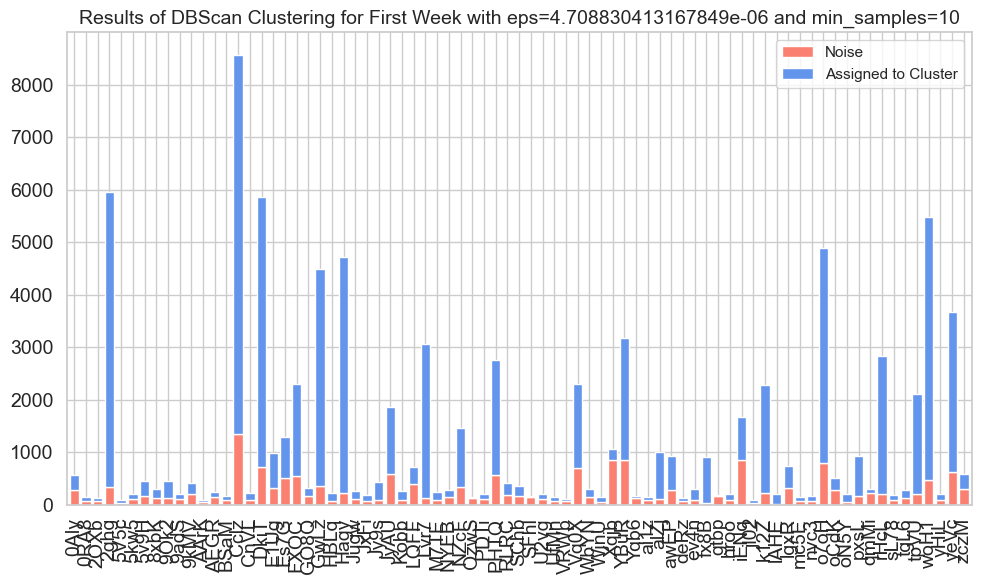

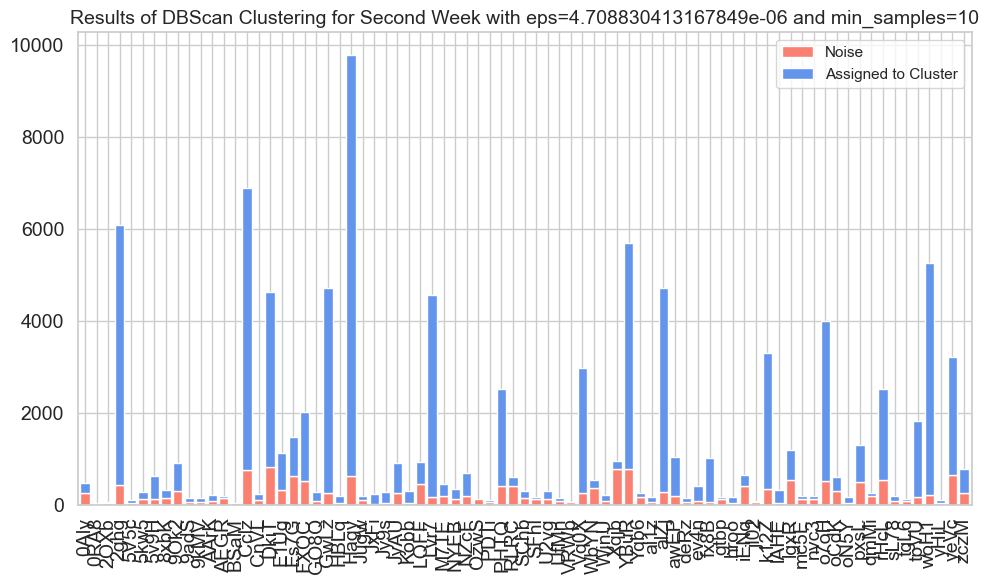

In [25]:
# Define the plotting function
def plot_cluster_counts(geodata_clusters, title):
    # Initializing a new DataFrame to store processed data
    plot_data = pd.DataFrame()

    # Calculating the count of "-" values per customer
    plot_data['negative_count'] = geodata_clusters[geodata_clusters['cluster_100m'] == -1].groupby('customer').size()

    # Calculating the count of non "-" values per customer
    plot_data['positive_count'] = geodata_clusters[geodata_clusters['cluster_100m'] != -1].groupby('customer').size()

    # Filling NaN with 0s (for customers with no "-" values)
    plot_data = plot_data.fillna(0)

    # Plotting
    ax = plot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'cornflowerblue'], width=0.8)
    plt.title(title, fontsize=14)
    plt.ylabel('')
    plt.xlabel('')

    # Adjusting the legend
    plt.legend(["Noise", "Assigned to Cluster"], loc='upper right')

    plt.savefig(f'{title}.png', dpi=300)
    # Showing the plot
    plt.tight_layout()
    plt.show()

# Plotting the results for first week
plot_cluster_counts(geodata_clusters_first, f'Results of DBScan Clustering for First Week with eps={epsilon} and min_samples={min_samples}')

# Plotting the results for second week
plot_cluster_counts(geodata_clusters_second, f'Results of DBScan Clustering for Second Week with eps={epsilon} and min_samples={min_samples}')

In [26]:
# Filter out noise points from geodata_clusters_first and geodata_clusters_second
geodata_clusters_first = geodata_clusters_first[geodata_clusters_first['cluster_100m'] != -1]
geodata_clusters_second = geodata_clusters_second[geodata_clusters_second['cluster_100m'] != -1]


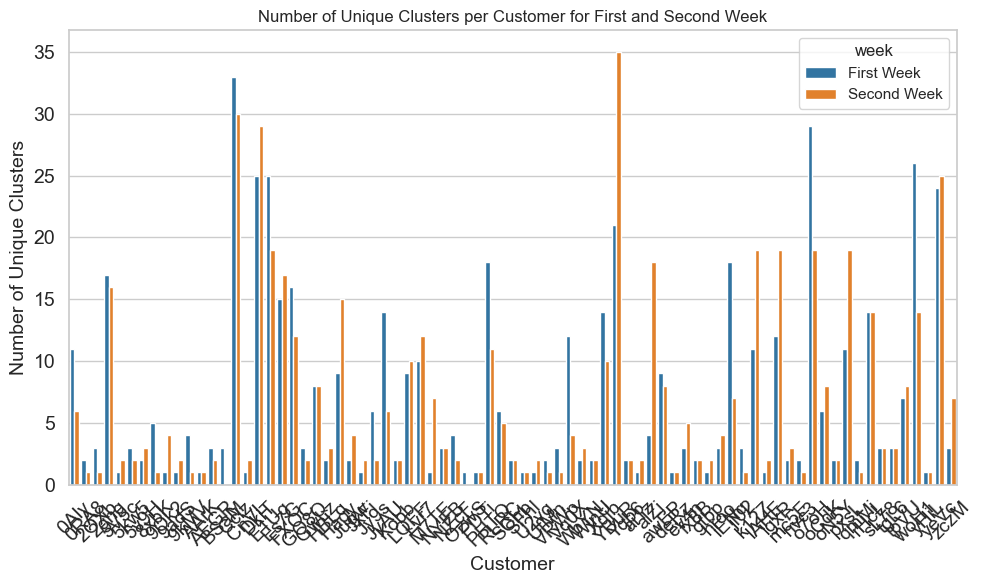

In [27]:
# Define the plotting function for unique clusters
def plot_unique_clusters(geodata_clusters_first, geodata_clusters_second, title):
    # Count unique clusters per customer for the first week
    unique_clusters_first = geodata_clusters_first.groupby('customer')['cluster_100m'].nunique().reset_index()
    unique_clusters_first['week'] = 'First Week'
    
    # Count unique clusters per customer for the second week
    unique_clusters_second = geodata_clusters_second.groupby('customer')['cluster_100m'].nunique().reset_index()
    unique_clusters_second['week'] = 'Second Week'
    
    # Combine the data from both weeks
    combined_unique_clusters = pd.concat([unique_clusters_first, unique_clusters_second])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='customer', y='cluster_100m', hue='week', data=combined_unique_clusters)
    plt.xlabel('Customer')
    plt.ylabel('Number of Unique Clusters')
    plt.title(title)
    plt.xticks(rotation=45)  # Rotate labels to avoid overlap, adjust as necessary
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
    plt.show()

# Example usage with provided dataframes
plot_unique_clusters(geodata_clusters_first, geodata_clusters_second, 'Number of Unique Clusters per Customer for First and Second Week')

In [28]:
# Generate unique IDs for clusters for first week using .loc
geodata_clusters_first.loc[:, 'clusterID'] = geodata_clusters_first['customer'].astype(str) + '00' + geodata_clusters_first['cluster_100m'].astype(str)

# Generate unique IDs for clusters for second week using .loc
geodata_clusters_second.loc[:, 'clusterID'] = geodata_clusters_second['customer'].astype(str) + '00' + geodata_clusters_second['cluster_100m'].astype(str)


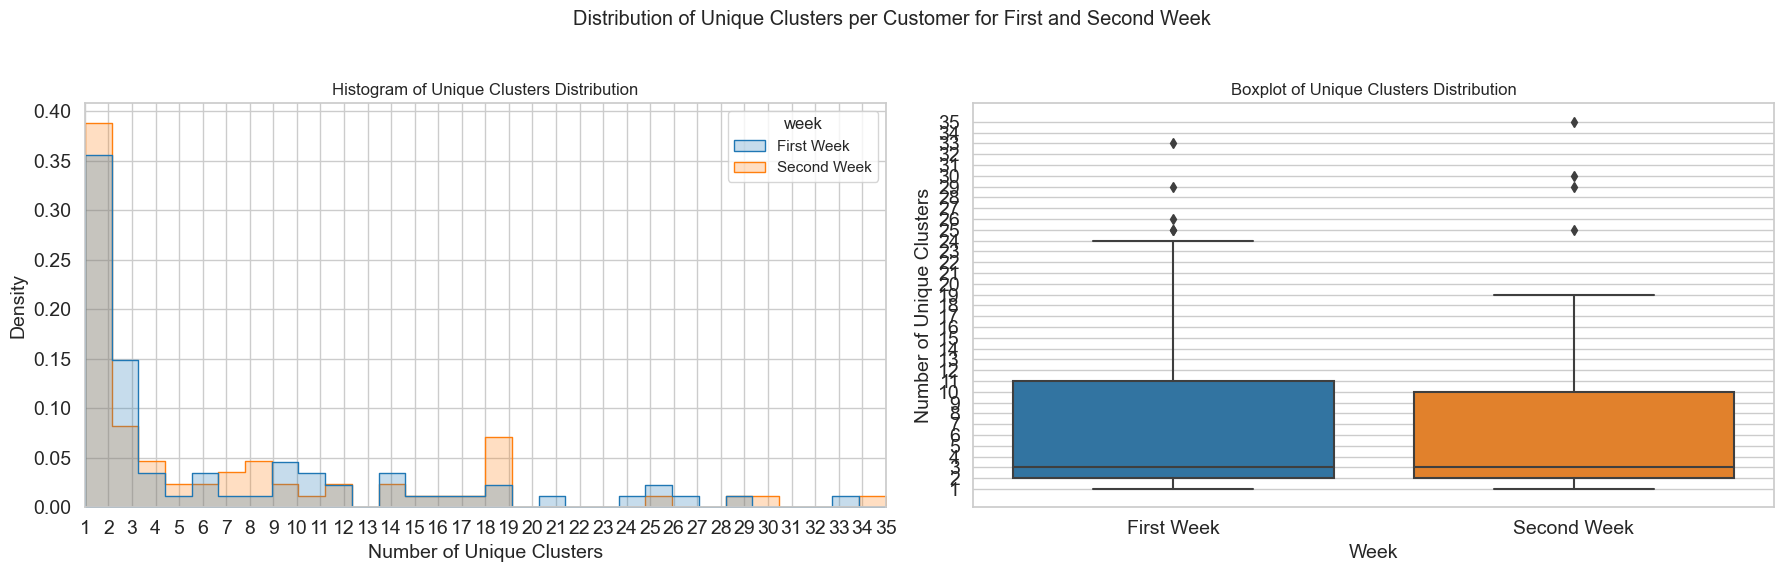

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the function to plot the distribution of unique clusters for the first and second week
def plot_unique_clusters_distribution(geodata_clusters_first, geodata_clusters_second, title):
    # Count unique clusters per customer for the first week
    unique_clusters_first = geodata_clusters_first.groupby('customer')['cluster_100m'].nunique().reset_index()
    unique_clusters_first['week'] = 'First Week'
    
    # Count unique clusters per customer for the second week
    unique_clusters_second = geodata_clusters_second.groupby('customer')['cluster_100m'].nunique().reset_index()
    unique_clusters_second['week'] = 'Second Week'
    
    # Combine the data from both weeks
    combined_unique_clusters = pd.concat([unique_clusters_first, unique_clusters_second])
    
    # Determine the range for x-axis ticks
    min_clusters = combined_unique_clusters['cluster_100m'].min()
    max_clusters = combined_unique_clusters['cluster_100m'].max()
    ticks = np.arange(min_clusters, max_clusters + 1, 1)
    
    # Plotting distributions
    plt.figure(figsize=(18, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=combined_unique_clusters, x='cluster_100m', hue='week', element='step', 
                 stat='density', common_norm=False, bins=30)
    plt.xlabel('Number of Unique Clusters')
    plt.ylabel('Density')
    plt.title('Histogram of Unique Clusters Distribution')
    plt.xlim(min_clusters, max_clusters)
    plt.xticks(ticks)
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x='week', y='cluster_100m', data=combined_unique_clusters)
    plt.xlabel('Week')
    plt.ylabel('Number of Unique Clusters')
    plt.title('Boxplot of Unique Clusters Distribution')
    plt.yticks(ticks)
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage with provided dataframes
plot_unique_clusters_distribution(geodata_clusters_first, geodata_clusters_second, 'Distribution of Unique Clusters per Customer for First and Second Week')


## Generate Home Location from data

In [29]:
def analyze_night_clusters(geodata_clusters, min_nights_obs, min_f_home):
    # Filter data for night hours (midnight to 6:00 am)
    geodata_night = geodata_clusters.loc[(geodata_clusters['hour_gps'] >= 20) | (geodata_clusters['hour_gps'] < 4)].copy()

    # Find the mode of clusterID per user during night hours
    geodata_night['home'] = geodata_night.groupby('customer')['clusterID'].transform(lambda x: statistics.mode(x))

    # Calculating various metrics to validate the home cluster
    geodata_night['nights_with_obs'] = geodata_night.groupby('customer')['day_gps'].transform('nunique')
    geodata_night['night_obs'] = geodata_night.groupby('customer')['day_gps'].transform('size')

    # Finding the frequency of the mode
    geodata_night['n_home'] = geodata_night.groupby('customer')['home'].transform(lambda x: x.value_counts().iloc[0])
    geodata_night['f_home'] = geodata_night['n_home'] / geodata_night['night_obs']

    # Updating the 'home' label based on conditions
    geodata_night['home'] = geodata_night.apply(
        lambda x: x['home'] if x['nights_with_obs'] >= min_nights_obs and x['f_home'] > min_f_home else None, axis=1
    )

    # Extracting a mapping of userID to home cluster
    user_home_mapping = geodata_night[['customer', 'home']].drop_duplicates()

    # Merging back to the full dataset
    geodata_clusters = pd.merge(geodata_clusters, user_home_mapping, on='customer', how='left')
    geodata_clusters['home'] = geodata_clusters['home'].replace([None], np.nan)

    return geodata_clusters, geodata_night

# Apply the function to both first week and second week data
geodata_clusters_first, geodata_night_first = analyze_night_clusters(geodata_clusters_first, min_nights_obs, min_f_home)
geodata_clusters_second, geodata_night_second = analyze_night_clusters(geodata_clusters_second, min_nights_obs, min_f_home)

In [30]:
geodata_clusters_first.columns

Index(['customer', 'startTimestamp', 'ema_start_date', 'Latitude', 'Longitude',
       'day_gps', 'hour_gps', 'weekday', 'week', 'n_data', 'n_data_day',
       'n_data_hour', 'transition_time_daily', 'transition_time_total',
       'distance', 'time_diff', 'speed', 'cluster_100m', 'clusterID', 'home'],
      dtype='object')

In [31]:
def calculate_and_merge_metrics(geodata_clusters):
    # Calculate general and daily entropy metrics
    general_entropy = calculate_metrics(geodata_clusters, group_by=['customer'])
    daily_entropy = calculate_metrics(geodata_clusters, group_by=['customer', 'day_gps'])

    # Merge the daily and general metrics on 'customer'
    merged_metrics = pd.merge(daily_entropy, general_entropy, on='customer', suffixes=('_daily', '_total'))
    geodata_clusters = pd.merge(geodata_clusters, merged_metrics, on=["customer", "day_gps"])

    return geodata_clusters

# Apply the metric calculation and merging function to both first week and second week data
geodata_clusters_first = calculate_and_merge_metrics(geodata_clusters_first)
geodata_clusters_second = calculate_and_merge_metrics(geodata_clusters_second)


## Merge with Activity data

In [32]:
geodata_clusters_first

,customer,startTimestamp,ema_start_date,Latitude,Longitude,day_gps,hour_gps,weekday,week,n_data,...,num_unique_clusters_daily,num_total_clusters_daily,raw_entropy_daily,entropy_total,normalized_entropy_total,total_distance_total,percentage_time_at_home_total,num_unique_clusters_total,num_total_clusters_total,raw_entropy_total
0,0Aly,2024-04-08 14:52:37,2024-04-08,24.017182,87.293762,2024-04-08,14,Monday,First Week,6235,...,6,6,1.397136,2.504085,0.444116,499286.341860,8.796516,11,11,0.390453
1,0Aly,2024-04-08 14:52:59,2024-04-08,24.017112,87.293382,2024-04-08,14,Monday,First Week,6235,...,6,6,1.397136,2.504085,0.444116,499286.341860,8.796516,11,11,0.390453
2,0Aly,2024-04-08 14:53:56,2024-04-08,24.016962,87.293382,2024-04-08,14,Monday,First Week,6235,...,6,6,1.397136,2.504085,0.444116,499286.341860,8.796516,11,11,0.390453
3,0Aly,2024-04-08 14:54:42,2024-04-08,24.017032,87.293312,2024-04-08,14,Monday,First Week,6235,...,6,6,1.397136,2.504085,0.444116,499286.341860,8.796516,11,11,0.390453
4,0Aly,2024-04-08 16:52:53,2024-04-08,24.018172,87.283992,2024-04-08,16,Monday,First Week,6235,...,6,6,1.397136,2.504085,0.444116,499286.341860,8.796516,11,11,0.390453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71307,zczM,2024-04-02 21:08:45,2024-03-26,3.706285,-70.372044,2024-04-02,21,Tuesday,First Week,3899,...,1,1,2.491904,3.297922,0.642883,54481.689771,81.982588,3,3,0.689069
71308,zczM,2024-04-02 21:08:55,2024-03-26,3.706255,-70.372024,2024-04-02,21,Tuesday,First Week,3899,...,1,1,2.491904,3.297922,0.642883,54481.689771,81.982588,3,3,0.689069
71309,zczM,2024-04-02 21:10:28,2024-03-26,3.706235,-70.372014,2024-04-02,21,Tuesday,First Week,3899,...,1,1,2.491904,3.297922,0.642883,54481.689771,81.982588,3,3,0.689069
71310,zczM,2024-04-02 21:11:16,2024-03-26,3.706235,-70.372014,2024-04-02,21,Tuesday,First Week,3899,...,1,1,2.491904,3.297922,0.642883,54481.689771,81.982588,3,3,0.689069


In [33]:
def reduce_and_deduplicate_geodata(geodata_clusters):
    columns_to_keep = ['customer', 'home','day_gps', 'n_data', 'n_data_day', 'n_data_hour',
                        'transition_time_daily', 'transition_time_total',
                       'distance', 'time_diff', 'speed', 'cluster_100m', 'clusterID',
                       'raw_entropy_daily', 'normalized_entropy_daily', 'total_distance_daily',
                       'percentage_time_at_home_daily', 'num_unique_clusters_daily',
                       'num_total_clusters_daily', 'raw_entropy_total',
                       'normalized_entropy_total', 'total_distance_total',
                       'percentage_time_at_home_total', 'num_unique_clusters_total',
                       'num_total_clusters_total', 'entropy_total', 'entropy_daily']

    # Reduce the dataframe to the specified columns
    geodata_cluster_red = geodata_clusters[columns_to_keep]

    # Drop duplicates based on 'customer' and 'day_gps'
    geodata_cluster_red = geodata_cluster_red.drop_duplicates(subset=['customer', 'day_gps'])

    return geodata_cluster_red

# Apply the function to both first week and second week data
geodata_cluster_red_first = reduce_and_deduplicate_geodata(geodata_clusters_first)
geodata_cluster_red_second = reduce_and_deduplicate_geodata(geodata_clusters_second)

In [34]:
geodata_cluster_red_first

,customer,home,day_gps,n_data,n_data_day,n_data_hour,transition_time_daily,transition_time_total,distance,time_diff,...,num_unique_clusters_daily,num_total_clusters_daily,raw_entropy_total,normalized_entropy_total,total_distance_total,percentage_time_at_home_total,num_unique_clusters_total,num_total_clusters_total,entropy_total,entropy_daily
0,0Aly,0Aly000,2024-04-08,6235,768,197,14.227488,7.688457,11.659858,18.0,...,6,6,0.390453,0.444116,499286.341860,8.796516,11,11,2.504085,1.607632
41,0Aly,0Aly000,2024-04-09,6235,1160,77,17.275942,7.688457,12.273540,32429.0,...,7,7,0.390453,0.444116,499286.341860,8.796516,11,11,2.504085,1.891458
90,0Aly,0Aly000,2024-04-10,6235,1045,300,11.014786,7.688457,12.636275,48444.0,...,6,6,0.390453,0.444116,499286.341860,8.796516,11,11,2.504085,1.084728
155,0Aly,0Aly000,2024-04-11,6235,2334,300,11.248383,7.688457,1.497409,321.0,...,2,2,0.390453,0.444116,499286.341860,8.796516,11,11,2.504085,0.682812
166,0Aly,0Aly000,2024-04-12,6235,681,2,9.813148,7.688457,0.000000,32933.0,...,7,7,0.390453,0.444116,499286.341860,8.796516,11,11,2.504085,2.099125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71154,zczM,zczM000,2024-03-29,3899,1504,51,8.632403,5.052240,4.003387,1200.0,...,1,1,0.689069,0.642883,54481.689771,81.982588,3,3,3.297922,1.429897
71181,zczM,zczM000,2024-03-30,3899,258,136,10.433783,5.052240,3.515558,45702.0,...,2,2,0.689069,0.642883,54481.689771,81.982588,3,3,3.297922,1.638721
71203,zczM,zczM000,2024-03-31,3899,359,21,11.551099,5.052240,6.749960,35573.0,...,1,1,0.689069,0.642883,54481.689771,81.982588,3,3,3.297922,0.530249
71206,zczM,zczM000,2024-04-01,3899,359,51,6.902590,5.052240,18.064664,39.0,...,1,1,0.689069,0.642883,54481.689771,81.982588,3,3,3.297922,1.473719


In [35]:
geodata_cluster_red = pd.merge(geodata_cluster_red_first, geodata_cluster_red_second, on="customer", how="inner",suffixes=('_first', '_second'))

In [36]:
geodata_cluster_red = geodata_cluster_red.drop_duplicates(subset=['customer'])


In [37]:
geodata_cluster_red.home_first.nunique()

68

In [38]:
geodata_cluster_red.home_second.nunique()

57

In [39]:
# Remove duplicate columns by renaming them
geodata_cluster_red = geodata_cluster_red.loc[:, ~geodata_cluster_red.columns.duplicated()]

# Verify the columns after removing duplicates
print(geodata_cluster_red.dtypes[["home_first", "home_second"]])

# Creating a boolean mask where home_first equals home_second
mask = geodata_cluster_red["home_first"] == geodata_cluster_red["home_second"]

# Using the mask to filter the DataFrame
result = geodata_cluster_red[mask]

# Selecting the desired columns for display
result_subset = result[["customer", "num_total_clusters_total_first", "num_total_clusters_total_second", "home_first", "home_second"]]

# Display the result
#import ace_tools as tools; tools.display_dataframe_to_user(name="Filtered Geodata Cluster", dataframe=result_subset)


home_first     object
home_second    object
dtype: object


In [40]:
result.columns

Index(['customer', 'home_first', 'day_gps_first', 'n_data_first',
       'n_data_day_first', 'n_data_hour_first', 'transition_time_daily_first',
       'transition_time_total_first', 'distance_first', 'time_diff_first',
       'speed_first', 'cluster_100m_first', 'clusterID_first',
       'raw_entropy_daily_first', 'normalized_entropy_daily_first',
       'total_distance_daily_first', 'percentage_time_at_home_daily_first',
       'num_unique_clusters_daily_first', 'num_total_clusters_daily_first',
       'raw_entropy_total_first', 'normalized_entropy_total_first',
       'total_distance_total_first', 'percentage_time_at_home_total_first',
       'num_unique_clusters_total_first', 'num_total_clusters_total_first',
       'entropy_total_first', 'entropy_daily_first', 'home_second',
       'day_gps_second', 'n_data_second', 'n_data_day_second',
       'n_data_hour_second', 'transition_time_daily_second',
       'transition_time_total_second', 'distance_second', 'time_diff_second',
       

In [41]:
# List of features to calculate retest reliability for
features = ['n_data_day', 'n_data_hour','total_distance_daily', 'total_distance_total',
            'num_unique_clusters_daily','num_unique_clusters_total',
            'num_total_clusters_daily', 'num_total_clusters_total','percentage_time_at_home_daily', 
            'percentage_time_at_home_total', 'raw_entropy_daily', 'normalized_entropy_daily',
           'raw_entropy_total', 'normalized_entropy_total', 'transition_time_daily',
            'transition_time_total', 'entropy_total', 'entropy_daily']

# Assume geodata_cluster_merged is your merged dataframe
# Calculate the retest reliability between the first and second week
correlation = calculate_retest_reliability(geodata_cluster_red, features)

# Print the results
for feature, correlation in correlation.items():
    print(f"Correlation for {feature} between first and second week: {correlation:.2f}")

Correlation for n_data_day between first and second week: 0.58
Correlation for n_data_hour between first and second week: 0.58
Correlation for total_distance_daily between first and second week: 0.42
Correlation for total_distance_total between first and second week: 0.29
Correlation for num_unique_clusters_daily between first and second week: 0.47
Correlation for num_unique_clusters_total between first and second week: 0.81
Correlation for num_total_clusters_daily between first and second week: 0.47
Correlation for num_total_clusters_total between first and second week: 0.81
Correlation for percentage_time_at_home_daily between first and second week: 0.15
Correlation for percentage_time_at_home_total between first and second week: 0.18
Correlation for raw_entropy_daily between first and second week: 0.33
Correlation for normalized_entropy_daily between first and second week: 0.34
Correlation for raw_entropy_total between first and second week: 0.25
Correlation for normalized_entropy_t

In [42]:
# List of features to calculate retest reliability for
features = ['percentage_time_at_home_daily', 'percentage_time_at_home_total']

# Assume geodata_cluster_merged is your merged dataframe
# Calculate the retest reliability between the first and second week
correlation = calculate_retest_reliability(result, features)

# Print the results
for feature, correlation in correlation.items():
    print(f"Correlation for {feature} between first and second week: {correlation:.2f}")

Correlation for percentage_time_at_home_daily between first and second week: 0.85
Correlation for percentage_time_at_home_total between first and second week: 0.60


## Calculate Retest Reliability

Evaluate the retest reliability of features between the first and second weeks using Pearson correlation.


In [43]:
import pingouin as pg
# List of features without the '_first' or '_second' suffixes
# List of features without the '_first' or '_second' suffixes


features = ['n_data_day', 'n_data_hour','total_distance_daily', 'total_distance_total',
            'num_unique_clusters_daily','num_unique_clusters_total',
            'num_total_clusters_daily', 'num_total_clusters_total', 'raw_entropy_daily', 'normalized_entropy_daily',
           'raw_entropy_total', 'normalized_entropy_total', 'transition_time_daily',
            'transition_time_total', 'entropy_total', 'entropy_daily']

# Dictionary to store ICC results
icc_results = {}

# Calculate ICC for each pair of columns
for feature in features:
    feature_first = feature + '_first'
    feature_second = feature + '_second'
    
    if feature_first in geodata_cluster_red.columns and feature_second in geodata_cluster_red.columns:
        # Drop rows with NaN values in the relevant columns
        clean_data = geodata_cluster_red[[feature_first, feature_second]].dropna()
        
        if len(clean_data) >= 5:
            # Create a DataFrame suitable for pingouin
            data = pd.DataFrame({
                'subject': clean_data.index,
                'first': clean_data[feature_first],
                'second': clean_data[feature_second]
            })
            
            # Melt the DataFrame to long format
            data_long = data.melt(id_vars='subject', var_name='rater', value_name='rating')
            
            # Calculate ICC(2,1) for single measurements
            icc = pg.intraclass_corr(data=data_long, targets='subject', raters='rater', ratings='rating', nan_policy='omit')
            print(f"ICC result for feature {feature}:")
            print(icc)
            if 'ICC2' in icc['Type'].values:
                icc_value = icc[icc['Type'] == 'ICC2']['ICC'].values[0]
                icc_results[feature] = icc_value
            else:
                print(f"ICC2 not found for feature {feature}")
                icc_results[feature] = np.nan
        else:
            print(f"Not enough non-missing values for feature {feature}.")
            icc_results[feature] = np.nan
    else:
        print(f"Feature columns for {feature} are missing in the dataframe.")


ICC result for feature n_data_day:
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.290112  1.817345   74   75  0.005341   
1   ICC2     Single random raters  0.323643  2.112389   74   74  0.000763   
2   ICC3      Single fixed raters  0.357407  2.112389   74   74  0.000763   
3  ICC1k  Average raters absolute  0.449747  1.817345   74   75  0.005341   
4  ICC2k    Average random raters  0.489018  2.112389   74   74  0.000763   
5  ICC3k     Average fixed raters  0.526602  2.112389   74   74  0.000763   

          CI95%  
0  [0.07, 0.48]  
1  [0.11, 0.51]  
2  [0.14, 0.54]  
3  [0.13, 0.65]  
4  [0.19, 0.68]  
5   [0.25, 0.7]  
ICC result for feature n_data_hour:
    Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.534526  3.296691   74   75  2.911096e-07   
1   ICC2     Single random raters  0.535750  3.334473   74   74  2.603056e-07   
2   ICC3      Single

ICC result for feature transition_time_daily:
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.150732  1.354970   74   75  0.095936   
1   ICC2     Single random raters  0.146566  1.339568   74   74  0.105471   
2   ICC3      Single fixed raters  0.145141  1.339568   74   74  0.105471   
3  ICC1k  Average raters absolute  0.261976  1.354970   74   75  0.095936   
4  ICC2k    Average random raters  0.255660  1.339568   74   74  0.105471   
5  ICC3k     Average fixed raters  0.253491  1.339568   74   74  0.105471   

           CI95%  
0  [-0.08, 0.36]  
1  [-0.08, 0.36]  
2  [-0.08, 0.36]  
3  [-0.17, 0.53]  
4  [-0.18, 0.53]  
5  [-0.18, 0.53]  
ICC result for feature transition_time_total:
    Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.562462  3.571028   74   75  5.389421e-08   
1   ICC2     Single random raters  0.562342  3.566578   74   74  6.357021

In [44]:
import pingouin as pg
# List of features without the '_first' or '_second' suffixes
# List of features without the '_first' or '_second' suffixes
features = ['percentage_time_at_home_daily', 'percentage_time_at_home_total',]

# Dictionary to store ICC results
icc_results = {}

# Calculate ICC for each pair of columns
for feature in features:
    feature_first = feature + '_first'
    feature_second = feature + '_second'
    
    if feature_first in result.columns and feature_second in result.columns:
        # Drop rows with NaN values in the relevant columns
        clean_data = result[[feature_first, feature_second]].dropna()
        
        if len(clean_data) >= 5:
            # Create a DataFrame suitable for pingouin
            data = pd.DataFrame({
                'subject': clean_data.index,
                'first': clean_data[feature_first],
                'second': clean_data[feature_second]
            })
            
            # Melt the DataFrame to long format
            data_long = data.melt(id_vars='subject', var_name='rater', value_name='rating')
            
            # Calculate ICC(2,1) for single measurements
            icc = pg.intraclass_corr(data=data_long, targets='subject', raters='rater', ratings='rating', nan_policy='omit')
            print(f"ICC result for feature {feature}:")
            print(icc)
            if 'ICC2' in icc['Type'].values:
                icc_value = icc[icc['Type'] == 'ICC2']['ICC'].values[0]
                icc_results[feature] = icc_value
            else:
                print(f"ICC2 not found for feature {feature}")
                icc_results[feature] = np.nan
        else:
            print(f"Not enough non-missing values for feature {feature}.")
            icc_results[feature] = np.nan
    else:
        print(f"Feature columns for {feature} are missing in the dataframe.")

ICC result for feature percentage_time_at_home_daily:
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.402020  2.344594   26   27  0.015819   
1   ICC2     Single random raters  0.432218  2.851914   26   26  0.004802   
2   ICC3      Single fixed raters  0.480778  2.851914   26   26  0.004802   
3  ICC1k  Average raters absolute  0.573487  2.344594   26   27  0.015819   
4  ICC2k    Average random raters  0.603565  2.851914   26   26  0.004802   
5  ICC3k     Average fixed raters  0.649358  2.851914   26   26  0.004802   

          CI95%  
0  [0.04, 0.67]  
1  [0.08, 0.69]  
2  [0.13, 0.72]  
3   [0.07, 0.8]  
4  [0.15, 0.82]  
5  [0.23, 0.84]  
ICC result for feature percentage_time_at_home_total:
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.543359  3.379813   26   27  0.001223   
1   ICC2     Single random raters  0.545304  3.444315   26   26  0.00121